In [118]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib import gridspec
import cv2
import os
import time
import pandas as pd
from model import TripletLoss
import skimage
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import keras
import keras.layers as klayers
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import skimage.transform

In [119]:
embedding_dims = 32
batch_size = 128
epochs = 30

In [120]:
from PIL import Image
data_src ='../pictures/folders/top100'
X = []
y = []
image_file_name = []
df = pd.DataFrame()
for directory in os.listdir(data_src):
    for pic in os.listdir(os.path.join(data_src, directory)):
        try:
            image_file_name.append(pic)
            img = cv2.imread(os.path.join(data_src, directory, pic))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = skimage.transform.resize(img, (28,28,1))
            norm_image = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

            img = norm_image.astype(np.uint8)
            X.append(np.squeeze((img)))
            y.append(directory)
    

            row =  img.ravel()
  
            a_series = pd.Series(row)
            df = df.append(a_series, ignore_index=True)
            # and convert to list
            row_as_list = row.tolist()
        except:
            continue


In [121]:
df.shape

(10523, 784)

In [122]:
label = y

In [124]:
from sklearn.preprocessing import LabelEncoder
label = pd.Series(label) 

labelencoder = LabelEncoder()

label = labelencoder.fit_transform(label)
label

array([93, 93, 93, ..., 67, 67, 67])

In [125]:
df = df.fillna(0)

In [126]:
#split 
train_x, test_x, train_y, test_y = train_test_split(df, label, test_size = 0.25, random_state = 2019)
print("train_x shape : ", train_x.shape)

print("valid_x shape : ", test_x.shape)


train_x shape :  (7892, 784)
valid_x shape :  (2631, 784)


In [127]:
#Split the training and validation dataset

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size = 0.25, random_state = 2019)
print("train_x shape : ", train_x.shape)

print("valid_x shape : ", valid_x.shape)


train_x shape :  (5919, 784)
valid_x shape :  (1973, 784)


In [128]:
train_y = pd.Series(train_y) 
valid_y = pd.Series(valid_y) 

In [129]:
test_y = pd.Series(test_y) 


In [130]:
train_x = np.asarray(train_x).reshape(-1,28,28,1)
valid_x = np.asarray(valid_x).reshape(-1,28,28,1)
train_y = np.asarray(train_y)
valid_y = np.asarray(valid_y)
num_classes = len(np.unique(train_y))

print("train_x shape : ", train_x.shape)
print("valid_x shape : ", valid_x.shape)

train_x shape :  (5919, 28, 28, 1)
valid_x shape :  (1973, 28, 28, 1)


In [131]:
test_x = np.asarray(test_x).reshape(-1,28,28,1)

test_y = np.asarray(test_y)

In [132]:
test_x.shape

(2631, 28, 28, 1)

In [133]:
print(num_classes)

92


In [134]:
def input_generator(x,y,batch_size):
    
    out_imgs = []
    out_labels = []
    
    data_len = len(x)
    
    while True:
        
        idx = np.random.choice(range(data_len))
        out_imgs.append(x[idx])
        out_labels.append(y[idx])
        
        if len(out_imgs) >= batch_size:
            yield np.stack(out_imgs), np.stack(out_labels)
            out_imgs = []
            out_labels = []
            
def augmentation_generator(input_gen, data_gen, batch_size, embedding_dims):
    
    
    dummy_y = np.zeros((batch_size, embedding_dims + 1))
    for data, label in input_gen:    
        x = data_gen.flow(data, batch_size = batch_size, shuffle = False)
        
        yield [next(x),label], dummy_y

In [135]:
train_data_generator = ImageDataGenerator(
                                    rescale = 1.0 / 255.0,
                                    rotation_range = 40,
                                    width_shift_range = 0.15,
                                    height_shift_range = 0.15,
                                    shear_range = 0.1,
                                    zoom_range = 0.1,
                                    )
valid_data_generator = ImageDataGenerator(rescale = 1.0/255.0)
train_input_gen = input_generator(train_x,train_y,batch_size)
valid_input_gen = input_generator(valid_x,valid_y,batch_size)

train_aug = augmentation_generator(train_input_gen, train_data_generator, batch_size, embedding_dims)
valid_aug = augmentation_generator(valid_input_gen, valid_data_generator, batch_size, embedding_dims)

In [137]:
def nn_relua(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "same"):
    
    def f(input_x):
        
        x = input_x
        x = klayers.Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding,
                          kernel_initializer = "he_normal")(x)
        x = klayers.BatchNormalization()(x)
        x = klayers.Activation("relu")(x)
        
        return x
    return f

def nn_relub(units = 256):
    def f(input_x):
        
        x = input_x
        x = klayers.Dense(units = units)(x)
        x = klayers.BatchNormalization()(x)
        x = klayers.Activation("relu")(x)
        
        return x
    return f
    
def build_model(image_input, embedding_dims):
    
    x = nn_relua(filters = 128, kernel_size = (3,3))(image_input)
    x = klayers.MaxPooling2D(pool_size = (2,2))(x)
    x = nn_relua(filters = 128, kernel_size = (3,3))(x)
    x = klayers.MaxPooling2D(pool_size = (2,2))(x)
    x = klayers.Dropout(0.35)(x)
    x = klayers.Flatten()(x)
    x = nn_relub(units = 256)(x)
    x = nn_relub(units = 128)(x)
    x = klayers.Dropout(0.25)(x)
    x = nn_relub(units = 64)(x)
    x = klayers.Dense(units = embedding_dims, name = "embedding_layer")(x)
    
    return x

image_input = klayers.Input(shape = train_x.shape[1:], name = "image_input")
label_input = klayers.Input(shape = (1,), name = "label_input")

base_model = build_model(image_input, embedding_dims)
output = klayers.concatenate([label_input, base_model])

model = keras.models.Model(inputs = [image_input, label_input], outputs = [output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 64)   640         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 28, 28, 64)   256         conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 28, 28, 64)   0           batch_normalization_11[0][0]     
__________________________________________________________________________________________________
max_poolin

In [138]:
def triplet_loss(y_true, y_pred, margin = 1.2):
    
    del y_true
    
    labels = y_pred[:,:1]
 
    labels = tf.reshape(labels, (tf.shape(labels)[0],))
    
    embeddings = y_pred[:,1:]
    return tf.contrib.losses.metric_learning.triplet_semihard_loss(labels = labels,
                                                                 embeddings = embeddings,
                                                                 margin = margin)

In [139]:


optimizer = keras.optimizers.Adam(lr = 1e-3, decay = 1e-8)
model.compile(optimizer = optimizer, loss = triplet_loss)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor = 0.5, mode = 'min', verbose = 1, min_lr = 1e-6)
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min')

steps_per_epoch = len(train_x) // batch_size
validation_steps = len(valid_x) // batch_size

In [140]:
validation_steps

15

In [141]:
history = model.fit_generator(train_aug, steps_per_epoch = steps_per_epoch,
                              epochs = epochs, verbose = 1,
                              validation_data = valid_aug, validation_steps = validation_steps,
                              shuffle = True, callbacks = [reduce_lr,es])

Epoch 1/30
46/46 [==============================] - 24s 519ms/step - loss: 0.9233 - val_loss: 0.6677
Epoch 2/30
46/46 [==============================] - 19s 412ms/step - loss: 0.7072 - val_loss: 1.2048
Epoch 3/30
46/46 [==============================] - 18s 389ms/step - loss: 0.8464 - val_loss: 0.8509
Epoch 4/30
46/46 [==============================] - 18s 389ms/step - loss: 0.6752 - val_loss: 0.7215

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/30
46/46 [==============================] - 18s 399ms/step - loss: 0.7126 - val_loss: 0.6134
Epoch 6/30
46/46 [==============================] - 17s 377ms/step - loss: 0.7477 - val_loss: 0.4890
Epoch 7/30
46/46 [==============================] - 17s 376ms/step - loss: 0.6552 - val_loss: 0.6069
Epoch 8/30
46/46 [==============================] - 18s 396ms/step - loss: 0.6222 - val_loss: 0.5668
Epoch 9/30
46/46 [==============================] - 18s 388ms/step - loss: 0.6918 - val_loss: 0.5339

Epoch 000

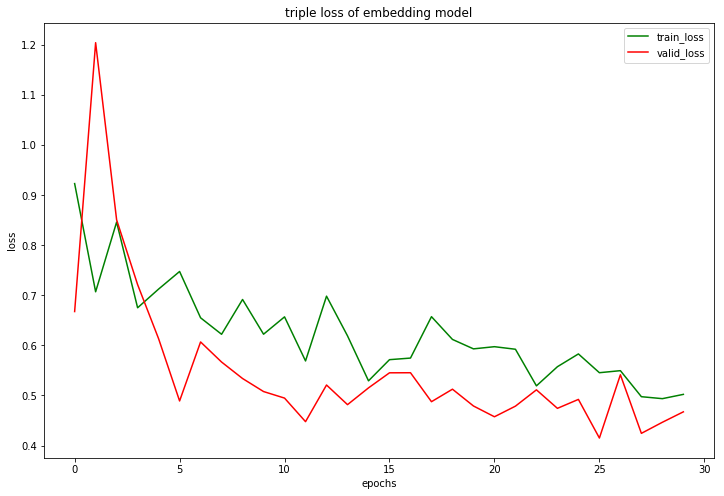

In [143]:
plt.figure(figsize = (12,8))
plt.plot(history.history['loss'], '-', label = 'train_loss', color = 'g')
plt.plot(history.history['val_loss'], '-', label = 'valid_loss', color = 'r')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('triple loss of embedding model')
plt.legend()
plt.show()

In [144]:
#Transfer the weights from original model to embedding model

image_input = klayers.Input(shape = train_x.shape[1:])
embedding_output = build_model(image_input, embedding_dims = embedding_dims)
embedding_model = keras.models.Model(inputs = [image_input], outputs = [embedding_output])

for idx in range(1,18):
    target_layer = embedding_model.layers[idx]
    source_layer = model.layers[idx]
    target_layer.set_weights(source_layer.get_weights())
    
embedding_model.layers[-1].set_weights(model.layers[-2].get_weights())

embedding_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
activation_16 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_17 (Batc (None, 14, 14, 64)        256       
__________

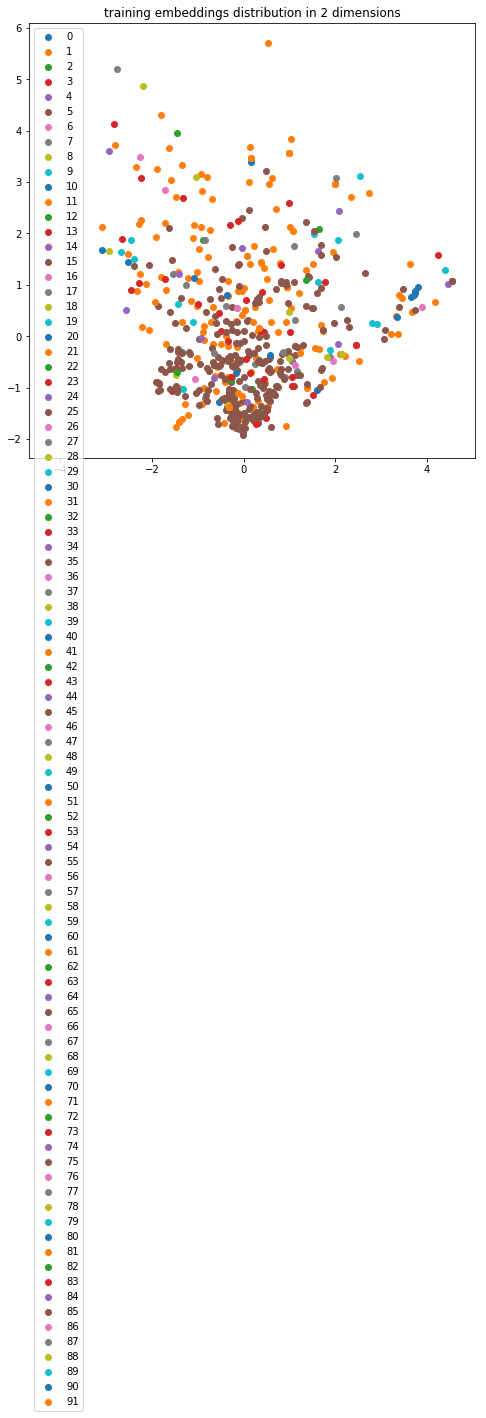

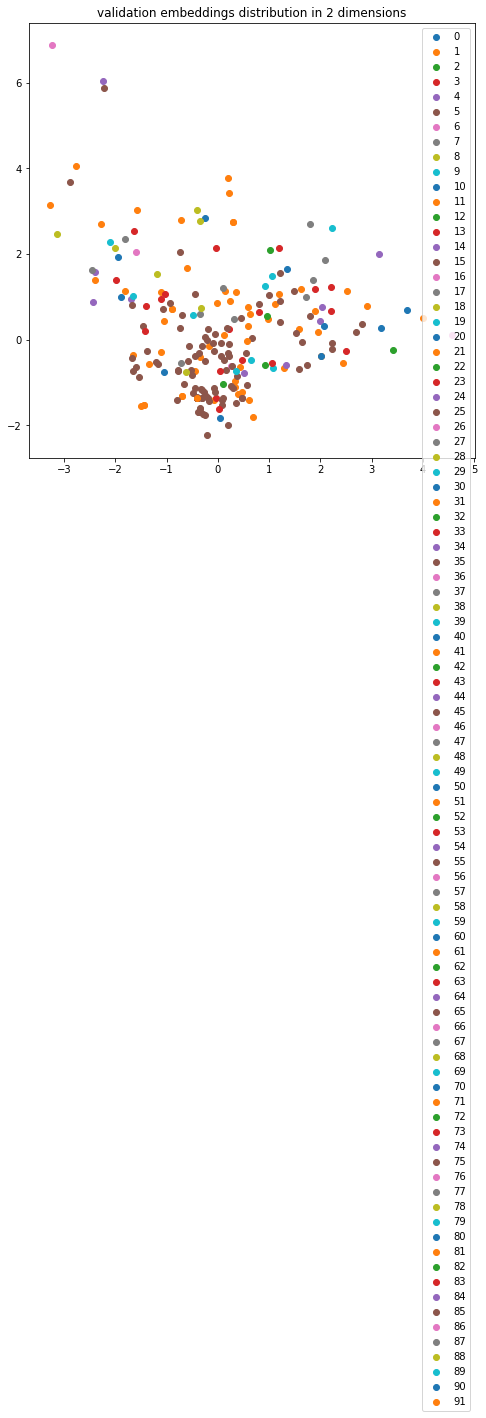

In [145]:
#Use PCA to check the effect of embedding model

def plot_2d_distribution(embedding_data, num_classes, y, steps = 10, title = ""):
    pca = PCA(n_components = 2)
    decomposed_data = pca.fit_transform(embedding_data)
    plt.figure(figsize = (8,8))
    for label in range(num_classes):
        
        decomposed_class = decomposed_data[label == y]
        plt.scatter(decomposed_class[::steps, 1], decomposed_class[::steps,0], label = str(label))
    plt.legend()
    plt.title(title)
    plt.show()
    

train_x_embeddings = embedding_model.predict(train_x/255.0)
valid_x_embeddings = embedding_model.predict(valid_x/255.0)

plot_2d_distribution(train_x_embeddings, num_classes, train_y, title = 'training embeddings distribution in 2 dimensions')
plot_2d_distribution(valid_x_embeddings, num_classes, valid_y, title = 'validation embeddings distribution in 2 dimensions')

In [146]:
#Use SVC to predict the final label of embedding data

svc = SVC()
svc.fit(train_x_embeddings, train_y)
valid_prediction = svc.predict(valid_x_embeddings)
print("validation accuracy : ", accuracy_score(valid_y, valid_prediction))

validation accuracy :  0.7060314242270653


In [85]:

test_x_embeddings = embedding_model.predict(test_x/255.0)

In [92]:
test_x_embeddings

array([[-0.01954285, -0.42308813,  0.30683386, ...,  0.02700181,
         0.10072266, -1.0153195 ],
       [ 0.3947805 , -0.24904469,  0.08077487, ...,  0.17984332,
         0.31035912,  0.1747558 ],
       [-0.41568753, -0.36316714,  0.27518046, ...,  1.8086039 ,
         0.36340353,  1.5902385 ],
       ...,
       [-0.43016195,  0.3524479 , -0.3739467 , ..., -0.03020405,
         0.06988655,  0.04273224],
       [-0.24522427,  0.3344899 , -0.49163783, ...,  0.09998452,
        -0.01273905,  0.18544619],
       [ 0.3811976 ,  0.1584693 ,  0.7356263 , ..., -0.5908749 ,
         0.1322501 , -0.1676595 ]], dtype=float32)

In [147]:
# Find k nearest neighbour using cosine similarity
def find_k_nn(normalized_train_vectors,vec,k):
    dist_arr = np.matmul(train_x_embeddings, vec.T)
    return np.argsort(-dist_arr.flatten())[:k]

In [93]:
s_time = time.time()
k = 10
candidate_index = find_k_nn(train_x_embeddings, test_x_embeddings[1,], k)

In [94]:
candidate_index

array([5341,  485, 3132, 1333, 5565,  201, 3949, 5128, 4959, 5620])

In [95]:
import pickle
pickle.dump(svc, open('svc_model.pickle','wb'))

In [158]:
# generate data for demo
from PIL import Image
data_src ='../co_check'
X_1 = []

image_file_name_1 = []
df = pd.DataFrame()
for pic in os.listdir(data_src):
    image_file_name_1.append(pic)
    img = cv2.imread(os.path.join(data_src, pic))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = skimage.transform.resize(img, (28,28,1))
    norm_image = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

    img = norm_image.astype(np.uint8)
    X_1.append(np.squeeze((img)))

    # Now you can flatten you array

    row =  img.ravel()
    #row = row.tolist()
    a_series = pd.Series(row)
    df = df.append(a_series, ignore_index=True)
    # and convert to list
    row_as_list = row.tolist()



In [159]:
os.path.join(data_src, directory, pic)

'../co_check/7/B0012G297S_0.jpg'

In [160]:
test_x_1 = np.asarray(X_1).reshape(-1,28,28,1)


In [161]:
test_x_embeddings_1 = embedding_model.predict(test_x_1/255.0)

In [167]:
#Generate 5 nearest neighbours for first image

image_file_name_1[3]

'B0013XWDGC_0.jpg'

In [162]:
test_x_embeddings_1

array([[ 1.14318967e-01, -3.00324440e-01,  2.28632951e+00,
         1.33086717e+00,  5.80934286e-01, -5.18571138e-01,
        -2.04780769e+00,  3.63703743e-02,  6.73986450e-02,
        -4.03818786e-01,  3.19708027e-02,  2.98814893e-01,
        -1.11685133e+00, -1.27800834e+00,  1.62591591e-01,
        -3.63939583e-01, -2.91759402e-01,  9.57871079e-01,
         3.03582996e-01, -1.32134926e+00, -8.50716114e-01,
        -1.63642859e+00, -8.73669624e-01,  7.67380595e-01,
         4.27618593e-01, -2.91966468e-01, -3.95621747e-01,
         8.78267109e-01, -8.71666431e-01, -1.30858868e-01,
         1.12966657e+00,  1.40743887e+00],
       [-6.83693439e-02, -3.24620515e-01,  2.19243407e+00,
         1.12028527e+00,  8.14192533e-01, -1.08613513e-01,
        -1.43142164e+00, -5.73549092e-01, -1.31511360e-01,
        -3.94887596e-01,  2.50920087e-01,  4.94498521e-01,
        -8.25805426e-01, -1.31484377e+00,  3.46144706e-01,
        -1.36637104e+00, -3.12488884e-01,  7.37646401e-01,
        -6.45

In [168]:
k = 5
candidate_index = find_k_nn(train_x_embeddings, test_x_embeddings_1[3], k)

In [169]:
candidate_index

array([3861, 1893, 3911,  659, 3072])

In [171]:
for i in candidate_index:
    print(image_file_name[i])

B000EQU15O_1.jpg
B001MCF8LG_4.jpg
B002XE3DBY_0.jpg
B004ZIGST0_0.jpg
B0057Y2ORQ_0.jpg


In [172]:
image_file_name_1[5]

'B01EUTM45A_0.jpg'